In [13]:
%load_ext autoreload
%autoreload 2
import pickle
import pandas as pd
import numpy as np
from astropy.table import QTable
from astropy import units as u
import astropy.cosmology.units as cu
from astropy import constants as const
from matplotlib import pyplot as plt

from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy as unp
from scipy.optimize import brentq

from nfw_profile_heating import NFWProfile

from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(70, 0.3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from mcxc_clusters_as_nfw import load_clusters
nfws = load_clusters()

/Users/eleanorstuart/Desktop/krisp/thermo-idm/mcxc_clusters_as_nfw.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=skipfooter)


In [3]:
sample_nfw = nfws[10]
sample_nfw.M500, sample_nfw.R500, sample_nfw.L500

(<Quantity 3.5275 1e+14 solMass>,
 <Quantity 1.0263 Mpc>,
 <Quantity 2.872451 1e+37 W>)

In [73]:
mchi = np.logspace(-4, 0)*u.GeV
sigma0 = 1e-27*u.cm**2
f_chi = 1
n = 0
rs = (np.array([0.1,1])*sample_nfw.R500)#np.logspace(-2, 0)*sample_nfw.R500

In [74]:
dQR500 = sample_nfw.vol_dm_cooling_rate(rs, sigma0, mchi[20])[-1]
dQR500

<Quantity 6.61214809e-32 erg / (cm3 s)>

In [75]:
rho_g500 = sample_nfw.rho_g(rs)[-1]
rho_g500

<Quantity 8.83768379e+12 solMass / Mpc3>

In [76]:
rs[-1]

<Quantity 1.0263 Mpc>

In [77]:
dm_temp_ev = (dQR500/rho_g500 * mchi[20] * 1/const.c**2).to(u.erg/ (u.s), equivalencies=[u.mass_energy(), u.temperature_energy()])
dm_temp_ev

<Quantity 8.45808193e-31 erg / s>

In [78]:
Tchi500 = sample_nfw.virial_temperature(rs, mchi[20])[-1]
Tchi500

<Quantity 5.90765307e-08 GeV>

In [79]:
Tb500 = sample_nfw.T_g(rs.value)[-1]
Tb500

<Quantity 8.45617769e-06 GeV>

In [80]:
dm_therm_rate = (dm_temp_ev/(Tb500 - Tchi500)).to(1/u.Gyr)
dm_therm_rate, mchi[20]

(<Quantity 1.98397446e-06 1 / Gyr>, <Quantity 0.00429193 GeV>)

In [82]:
def thermalization_rate(nfw, mchi, sigma0):
    f_chi = 1
    n = 0
    rs = (np.array([0.1,1])*sample_nfw.R500)#np.logspace(-2, 0)*sample_nfw.R500
    dQR500 = nfw.vol_dm_cooling_rate(rs, sigma0, mchi)[-1]
    rho_g500 = nfw.rho_g(rs)[-1]
    dm_temp_ev = (dQR500/rho_g500 * mchi * 1/const.c**2).to(u.erg/ (u.s), equivalencies=[u.mass_energy(), u.temperature_energy()])
    Tchi500 = nfw.virial_temperature(rs, mchi)[-1]
    Tb500 = nfw.T_g(rs.value)[-1]
    dm_therm_rate = (dm_temp_ev/(Tb500 - Tchi500)).to(1/u.Gyr)
    return dm_therm_rate

In [88]:
therm_rates = [thermalization_rate(sample_nfw, m, sigma0).value for m in mchi]

Text(0.5, 0, 'mchi (GeV)')

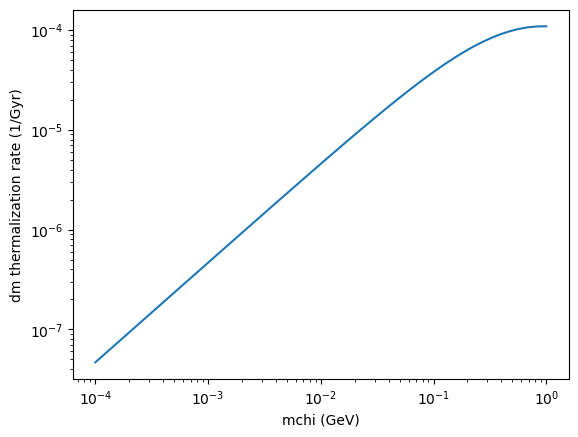

In [91]:
plt.loglog(mchi, therm_rates)
plt.ylabel('dm thermalization rate (1/Gyr)')
plt.xlabel('mchi (GeV)')